In [1]:
from oracle_w_fuzzy import load_data

In [2]:
data = load_data()

In [3]:
def get_meta_data(data):
    res = {}
    for k, v in data['training_data']['X'].max().to_dict().items():
        res[k] = {'max': v}
    for k, v in data['training_data']['X'].min().to_dict().items():
        res[k].update({'min': v})    
    return res

In [4]:
get_meta_data(data)

{'sepal_length': {'max': 7.9, 'min': 4.4},
 'sepal_width': {'max': 4.4, 'min': 2.2}}

<AxesSubplot:>

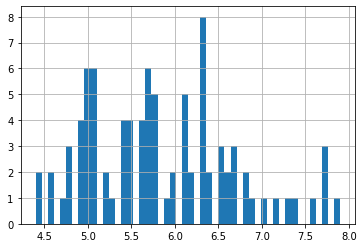

In [5]:
data['training_data']['X'].sepal_length.hist(bins=50)

<AxesSubplot:>

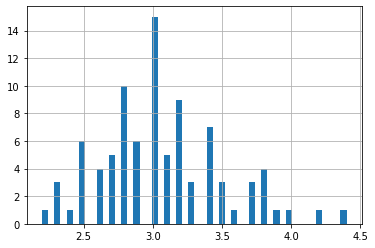

In [6]:
data['training_data']['X'].sepal_width.hist(bins=50)

<AxesSubplot:>

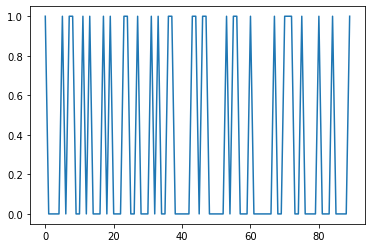

In [7]:
data['training_data']['y'].plot()

In [8]:
import numpy as np
from h1st.model.fuzzy import (
    FuzzyVariables,
    FuzzyMembership as fm,
    FuzzyRules,
    FuzzyModeler
)


meta_data = get_meta_data(data)
fuzzy_vars = FuzzyVariables()
fuzzy_vars.add(
    var_name='sepal_length',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['sepal_length']['min'], 
        meta_data['sepal_length']['max'], 
        0.1
    ),
    membership_funcs=[('small', fm.GAUSSIAN, [5, 1]),
                        ('large', fm.TRIANGLE, [6, 6.4, 8])]
)
fuzzy_vars.add(
    var_name='sepal_width',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['sepal_width']['min'], 
        meta_data['sepal_width']['max'], 
        0.1
    ),
    membership_funcs=[('small', fm.GAUSSIAN, [2.8, 0.3]),
                        ('large', fm.GAUSSIAN, [3.3, 0.5])]
)
fuzzy_vars.add(
    var_name='setosa',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                        ('true', fm.GAUSSIAN, [1, 0.4])]
)

fuzzy_rule = FuzzyRules()
fuzzy_rule.add(
    'rule1',
    if_=fuzzy_vars.sepal_length['small'] & fuzzy_vars.sepal_width['large'],
    then_=fuzzy_vars.setosa['false']
)
fuzzy_rule.add(
    'rule2',
    if_=fuzzy_vars.sepal_length['large'] & fuzzy_vars.sepal_width['small'],
    then_=fuzzy_vars.setosa['true']
)

modeler = FuzzyModeler()
model = modeler.build_model(fuzzy_rule)

In [9]:
temp = model.predict(data['training_data'])['predictions']